In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
import pickle

In [2]:
s=0.2
Jx=1
Jy=2
Jz=1
h=0.5
number_wires=10
plot_wires=6

In [3]:
file_name="energies.pkl"
open_file = open(file_name, "rb")
energies = pickle.load(open_file)
open_file.close()

In [4]:
def apply_Pauli_noise(wire, noise_probability, noise_strength):
    if np.random.rand() < noise_probability:
        qml.RX(noise_strength, wires=wire)
    if np.random.rand() < noise_probability: 
        qml.RY(noise_strength, wires=wire)
    if np.random.rand() < noise_probability: 
        qml.RZ(noise_strength, wires=wire)  
        
def create_Heisenberg_Hamiltonian(Jx,Jy,Jz,h,number_wires):
    couplings = [-Jx]*number_wires+[-Jy]*number_wires+[-Jz]*number_wires+[-h]*number_wires
    ops=[qml.PauliX(0)@qml.PauliX(1)]
    for i in range(number_wires-1):
        ops=ops+[qml.PauliX(i+1)@qml.PauliX((i+2)%number_wires)]
    for i in range(number_wires):
        ops=ops+[qml.PauliY(i)@qml.PauliY((i+1)%number_wires)]
    for i in range(number_wires):
        ops=ops+[qml.PauliZ(i)@qml.PauliZ((i+1)%number_wires)]
    for i in range(number_wires):
        ops=ops+[qml.PauliZ(i)]
    return qml.Hamiltonian(couplings,ops)

backend="default.mixed"
dev = qml.device(backend, wires=number_wires)
@qml.qnode(dev)
def model(params,H,p,s,number_wires):
    for i in range(number_wires):
        qml.RY(params[i], wires=i)
    for i in range(number_wires):
        qml.CNOT([i,(i+1)%number_wires])
        apply_Pauli_noise(i,p,s)
        apply_Pauli_noise((i+1)%number_wires,p,s)
    for i in range(number_wires):
        qml.RZ(params[i+number_wires], wires=i)
    for i in range(number_wires):
        qml.RY(params[i+2*number_wires], wires=i)
    for i in range(number_wires):
        qml.CNOT([i,(i+1)%number_wires])
        apply_Pauli_noise(i,p,s)
        apply_Pauli_noise((i+1)%number_wires,p,s)
    for i in range(number_wires):
        qml.RZ(params[i+3*number_wires], wires=i)
    return qml.expval(H)

def draw_circuit_nice(function:qml.qnode, **kwargs):
    "draw quantum function from pennylane in a nice visual format"
    qml.drawer.use_style("black_white")
    fig, ax = qml.draw_mpl(function)(**kwargs)
    plt.show()
    
def ED_groundstate(number_wires,Jx,Jy,Jz,h):
    H=create_Heisenberg_Hamiltonian(Jx,Jy,Jz,h,number_wires)
    Hmat = qml.utils.sparse_hamiltonian(H).toarray()
    eigvals,eigvectors=np.linalg.eig(Hmat)
    print("true minimum =",np.min(eigvals))
    return np.min(eigvals)

true minimum = (-20.63098733185136+0j)


/opt/conda/envs/pennylane/lib/python3.9/site-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


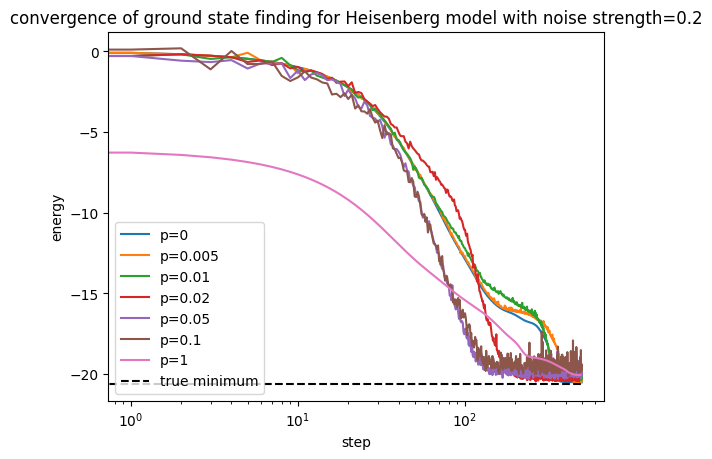

In [5]:
ps=[0,0.005,0.01,0.02,0.05,0.1,0.5,1]
for i,energy in enumerate(energies):
    if ps[i]!=0.5:
        plt.plot(np.array(energy),label="p={}".format(ps[i]))
true_min=ED_groundstate(number_wires,Jx,Jy,Jz,h)
plt.hlines(true_min,linestyle="dashed",xmin=0,xmax=500,label="true minimum",color="k")
plt.title("convergence of ground state finding for Heisenberg model with noise strength={}".format(s))
plt.xlabel("step")
plt.ylabel("energy")
plt.xscale("log")
plt.legend()
plt.savefig("convergence.pdf")

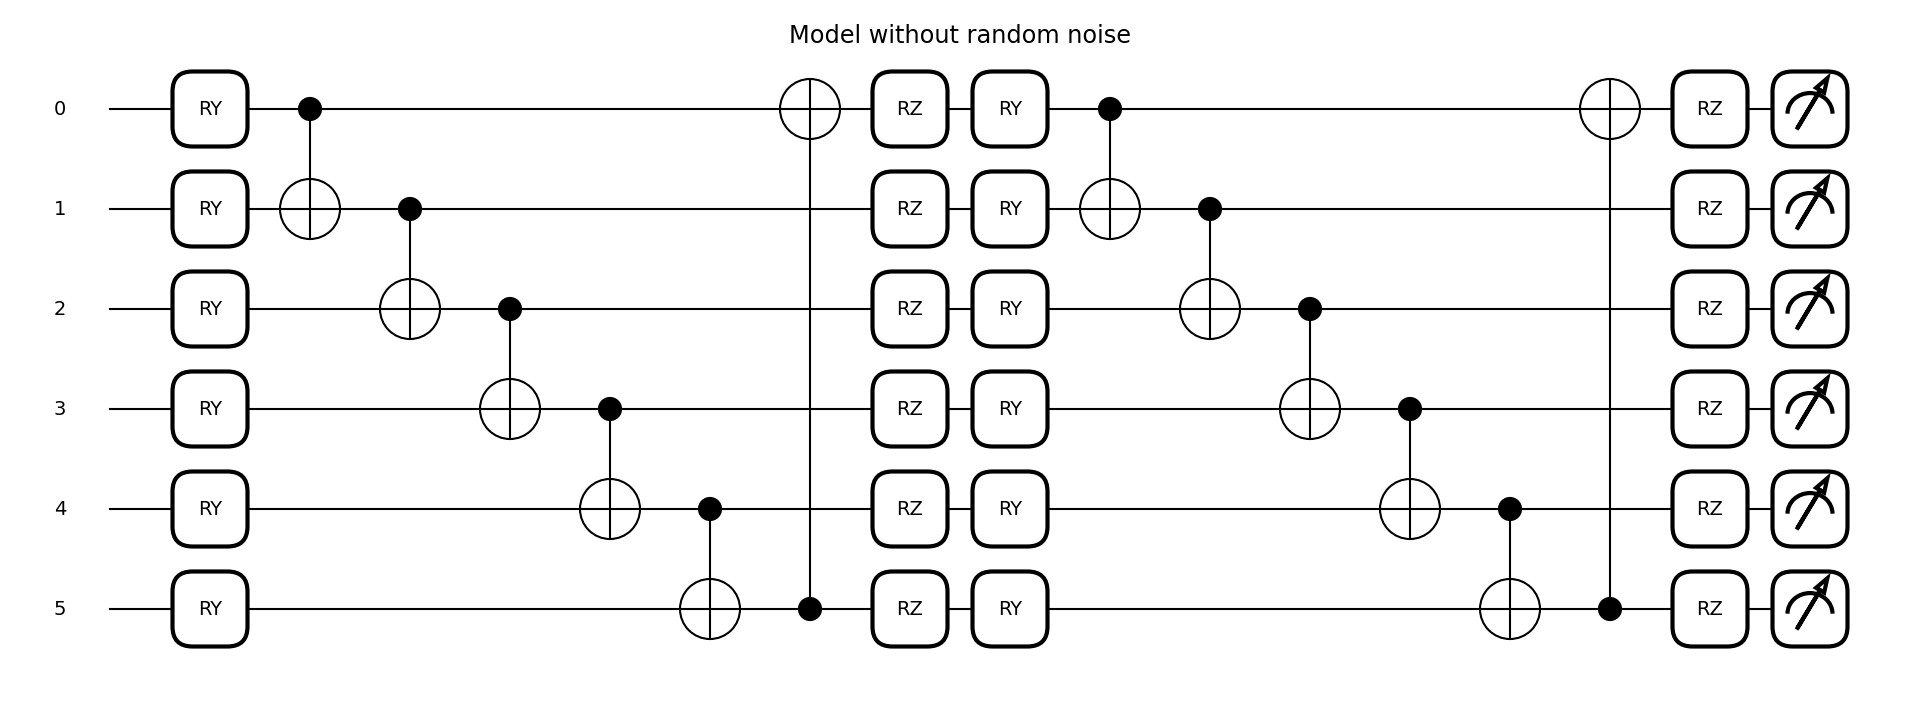

In [6]:
#plot noiseless model
theta = np.array([np.pi/2 for i in range(4*plot_wires)], requires_grad=True)
fig, ax = qml.draw_mpl(model)(params=theta,H=create_Heisenberg_Hamiltonian(Jx,Jy,Jz,h,plot_wires),p=0,s=0.2,number_wires=plot_wires)
fig.suptitle("Model without random noise", fontsize="xx-large")
fig.show()
fig.savefig("noiseless_model.pdf")

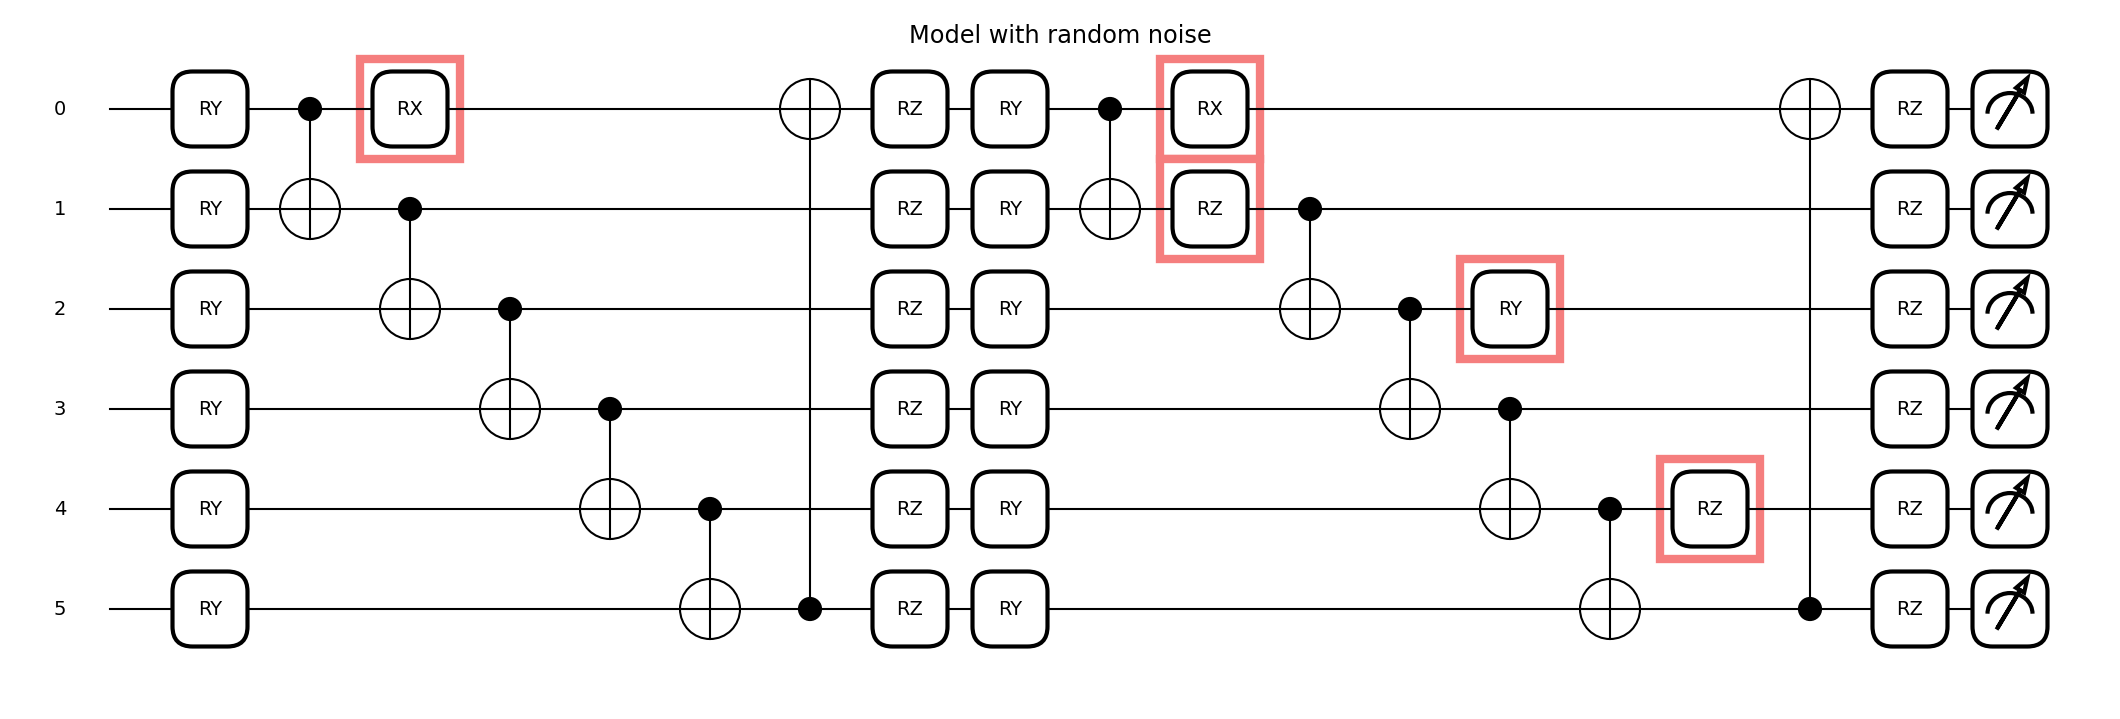

In [7]:
#plot noisy model
theta = np.array([np.pi/2 for i in range(4*plot_wires)], requires_grad=True)
np.random.seed(809224)


fig, ax = qml.draw_mpl(model)(params=theta,H=create_Heisenberg_Hamiltonian(Jx,Jy,Jz,h,plot_wires),p=0.05,s=0.2,number_wires=plot_wires)
fig.suptitle("Model with random noise", fontsize="xx-large")

boxes=[]
options = {'facecolor': "white", 'edgecolor': "#f57e7e", "linewidth": 6, "zorder": -1}
boxes.append(plt.Rectangle((1.5, -0.5), width=1.0, height=1.0, **options))
boxes.append(plt.Rectangle((9.5, -0.5), width=1.0, height=1.0, **options))
boxes.append(plt.Rectangle((9.5, 0.5), width=1.0, height=1.0, **options))
boxes.append(plt.Rectangle((12.5, 1.5), width=1.0, height=1.0, **options))
boxes.append(plt.Rectangle((14.5, 3.5), width=1.0, height=1.0, **options))
for box in boxes:
    ax.add_patch(box)
fig.show()
fig.savefig("noisy_model.pdf")